# thermodynamic/equilibrium analysis - state energies, spatial tolerance energy

This notebook is for when we have already built a transition matrix for a desired pattern that we wish to analyze for its thermodynamics and have already developed a generalized CTMC with analytical spatial tolerance function. The cells in this notebook will compute equilibrium state probabilities and use this information to derive other thermodynamic data such as state energies.


In [369]:
import math
import numpy as np
import complete_ctmc_v1 as ctmc
import os
import imp
import scipy.optimize as opt
import ipdb
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
from scipy import stats
import matplotlib.cm as cm
from tqdm import tqdm
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
plt.rcParams.update(new_rc_params)

plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25) 
plt.rcParams.update({'font.size': 25})

In [370]:
### PARAMETERS ###
time_points = np.array([0,10000,20000])
final_time = 30000
concentrations = np.array([0.01,.1,2]) # nM
mono_rates = np.array([0.02132598786, 0.0005306938055585968]) #nM-1 s-1  and s-1
# spatial_tolerance_file = "spatolIgG1_DIG.txt"
master_name = "output_hexparamd"
if not os.path.exists(master_name+"/pickle_directory"):
            os.makedirs(master_name+"/pickle_directory")

[0.01 0.01 0.01 ... 2.   2.   2.  ]
0.7033333333333334


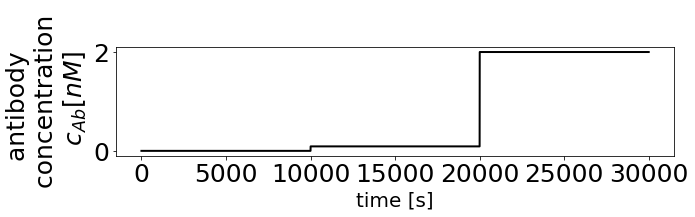

[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [9.99573622e-01 7.08651276e-05 7.08651276e-05 2.84626872e-04
  2.05449447e-08]
 [9.99147463e-01 9.39198348e-05 9.39198348e-05 6.64641500e-04
  5.57659346e-08]
 ...
 [1.24753597e-04 1.00264735e-02 1.00264735e-02 1.73992458e-01
  8.05829841e-01]
 [1.24753597e-04 1.00264735e-02 1.00264735e-02 1.73992458e-01
  8.05829841e-01]
 [1.24753597e-04 1.00264735e-02 1.00264735e-02 1.73992458e-01
  8.05829841e-01]]


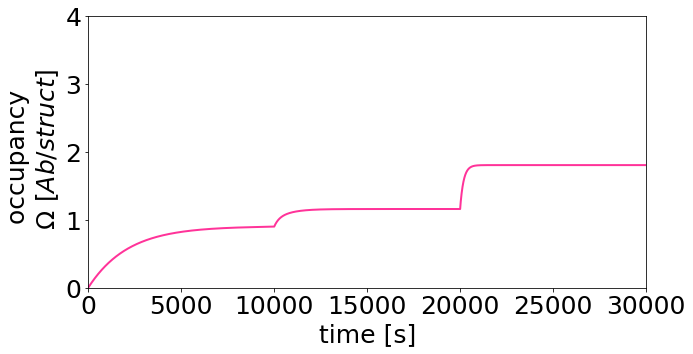

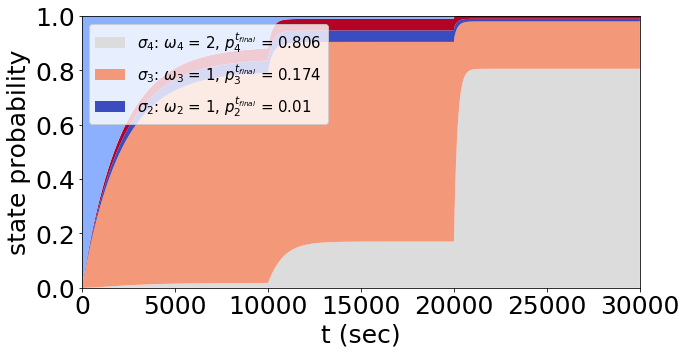

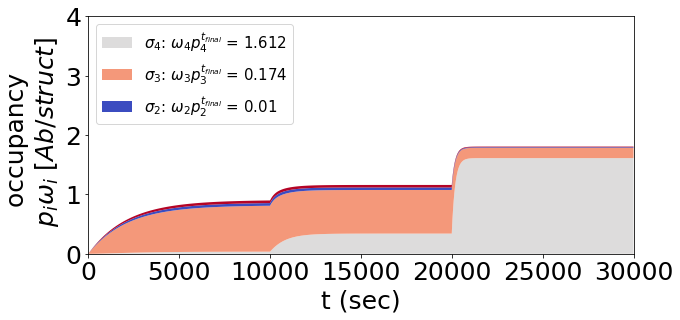

0

In [371]:
output_directory = master_name+"/denovo_sims"
if not os.path.exists(output_directory):
            os.makedirs(output_directory)
time_points
weighted_concs = np.zeros((final_time))
timepoints_new = list(time_points) + [final_time]
for i in range(0, len(time_points)):
    for j in range(timepoints_new[i],timepoints_new[i+1]):
        weighted_concs[j] = concentrations[i]
print(weighted_concs)   
fixed_conc = np.average(weighted_concs)
print(fixed_conc)
plt.figure(figsize=(10, 2))
plt.plot(weighted_concs,c="k", linewidth=2)
plt.ylabel("antibody \n concentration \n $c_{Ab} [nM]$",fontsize=25)
plt.xlabel("time [s]",fontsize=20)
plt.savefig(output_directory+"/concentration_injections.svg")
plt.show()
plt.close()
# imp.reload(ctmc)
### load a spatol model from file ###
KD_fx = [25.4726412,  0.27,       1.1,        0.33,       0.99]
denovo_sim_0 = ctmc.Simulation(transition_matrix_name = "bivalent_close",
                             mono_rates = mono_rates, 
                             KD_fx = KD_fx,
                             concentrations = concentrations, 
                             time_points = time_points, 
                             final_time = final_time) 
denovo_sim_0.print_graph=True
denovo_sim_0.SPR_run()
# stationary_distribution = denovo_sim_1.stationary_distribution(concentration = 1.,guess_init=np.ones((len(denovo_sim_1.occupancy_key))) / len(denovo_sim_1.occupancy_key)) #e-10 M 
# print("STATIONARY DISTRIBUTION: ",stationary_distribution)

[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [9.99978626e-01 3.18865856e-06 3.18865856e-06 1.49966772e-05
  4.74217443e-11]
 [9.99957254e-01 4.19369177e-06 4.19369177e-06 3.43585457e-05
  1.26411981e-10]
 ...
 [2.72626259e-04 1.37921770e-02 1.37921770e-02 2.74396047e-01
  6.97746973e-01]
 [2.72626259e-04 1.37921770e-02 1.37921770e-02 2.74396047e-01
  6.97746973e-01]
 [2.72626259e-04 1.37921770e-02 1.37921770e-02 2.74396047e-01
  6.97746973e-01]]


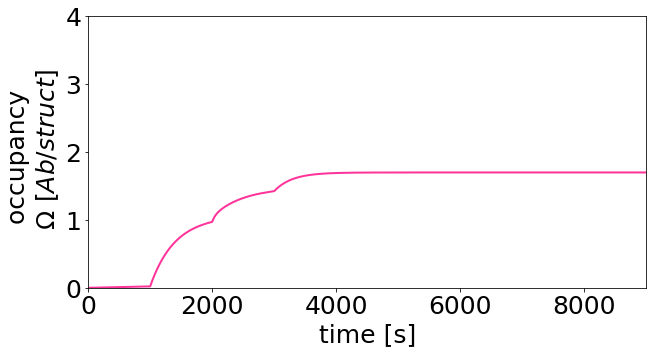

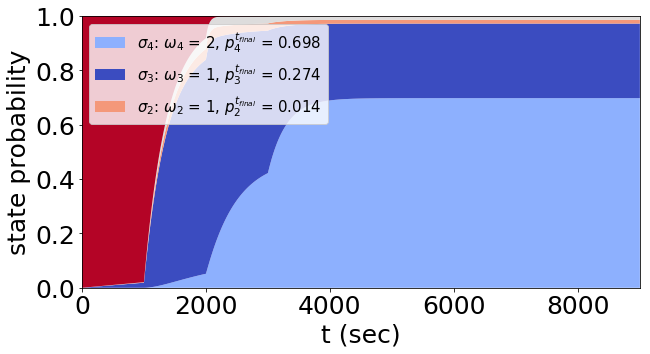

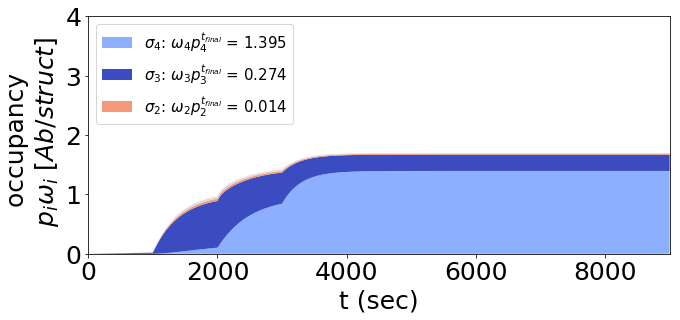

100%|██████████| 400/400 [35:02<00:00,  5.26s/it]


AttributeError: Simulation instance has no attribute 'subconc'

In [649]:
imp.reload(ctmc)
KD_fx = [25.4726412,  0.27,       1.1,        0.33,       0.99]
denovo_sim_1 = ctmc.Simulation(transition_matrix_name = "14p4_bivalent", #triangle_asym
                             mono_rates = mono_rates, 
                             KD_fx = KD_fx,
                             concentrations = concentrations, 
                             time_points = time_points, 
                             final_time = final_time) 
denovo_sim_1.print_graph=True
denovo_sim_1.SPR_run()
log_step = 0.005
concentrations_phaseplot1 = np.power(10.,np.arange(-5.,0.,log_step)[::-1])
phase_set1 = [] 
conc_set1  = []
# stationary_p =  np.ones((len(denovo_sim_1.occupancy_key))) / len(denovo_sim_1.occupancy_key)

for conc in tqdm(range(0,len(concentrations_phaseplot1))):
    repeat = True
    while repeat == True:
        repeat = False
        stationary_p = np.ones(len(denovo_sim_1.occupancy_key))
        stationary_p = stationary_p/np.sum(stationary_p)
        stationary_p_test = denovo_sim_1.stationary_distribution(concentration = concentrations_phaseplot1[conc],guess_init = stationary_p)
        for point in range(0,len(stationary_p_test)):
            if math.isnan(stationary_p_test[point]) or np.sum(stationary_p_test) != 1 or stationary_p_test[point]<0:
                repeat = True
                concentrations_phaseplot1[conc] = np.power(10,np.log10(concentrations_phaseplot1[conc])+log_step*np.random.normal(scale=0.1))
                
                break
    #             print("numerical solver failure, trying new conc: ", concentrations_phaseplot1[conc] )
        if repeat == False:
            stationary_p = stationary_p_test
            phase_set1.append(stationary_p)
            conc_set1.append(concentrations_phaseplot1[conc])
#             repeat = False
#             break
concentrations_phaseplot2 = np.power(10,np.arange(0.,2.,log_step))
phase_set2 = []
conc_set2  = []
stationary_p =  np.ones((len(denovo_sim_1.occupancy_key))) / len(denovo_sim_1.occupancy_key)
for conc in tqdm(range(0,len(concentrations_phaseplot2))):
    repeat = True
    while repeat == True:
        repeat = False
        stationary_p = np.ones(len(denovo_sim_1.occupancy_key))
        stationary_p = stationary_p/np.sum(stationary_p)
        stationary_p_test = denovo_sim_1.stationary_distribution(concentration = concentrations_phaseplot2[conc],guess_init = stationary_p)
        for point in range(0,len(stationary_p_test)):        
            if math.isnan(stationary_p_test[point]) or np.sum(stationary_p_test) != 1 or stationary_p_test[point]<0:
                repeat = True
                concentrations_phaseplot2[conc] = np.power(10,np.log10(concentrations_phaseplot2[conc])+log_step*np.random.normal(scale=0.1))
                break
#             print("numerical solver failure, trying new conc: ", concentrations_phaseplot2[conc] )
#         else:
        if repeat == False:
            stationary_p = stationary_p_test
            phase_set2.append(stationary_p)
            conc_set2.append(concentrations_phaseplot2[conc])

concentrations_phaseplot_merge =  np.array(conc_set1[::-1] + conc_set2)
phase_set_merge =  np.concatenate((np.array(phase_set1)[::-1], np.array(phase_set2)))

#################



imp.reload(ctmc)
molar_concentrations = np.log10(concentrations_phaseplot_merge*10**-9)

entropies = []
free_energies = []
energies = []
chem_pots = []
for conc in range(0,len(concentrations_phaseplot_merge)):
    entropy = np.array(-1*denovo_sim_1.kB*phase_set_merge[conc]*np.log(phase_set_merge[conc]))
    entropies.append(entropy)
    denovo_sim_1.subconc = molar_concentrations[conc]
    q, e_vector = denovo_sim_1.solve_partition_function(phase_set_merge[conc],verbose=False)
    free_energy = np.array(e_vector)*phase_set_merge[conc] -(denovo_sim_1.particle_count_key.T[0]*denovo_sim_1.mu_mono*np.array(phase_set_merge[conc]) + denovo_sim_1.particle_count_key.T[1]*denovo_sim_1.mu_biv*np.array(phase_set_merge[conc]))- entropy
    chem_pot = (denovo_sim_1.particle_count_key.T[0]*denovo_sim_1.mu_mono*np.array(phase_set_merge[conc]) + denovo_sim_1.particle_count_key.T[1]*denovo_sim_1.mu_biv*np.array(phase_set_merge[conc]))
    energies.append(e_vector*phase_set_merge[conc])
    free_energies.append(free_energy)
    chem_pots.append(chem_pot)
    
energies =    np.array([i for i in energies])       
entropies =    np.array([i for i in entropies])      
free_energies = np.array([i for i in free_energies])      
chem_pots = np.array([i for i in chem_pots]) 
# import pickle as pkl

# import pickle as pkl
# denovo_sim_1,molar_concentrations,phase_set_merge, \
#           entropies, energies = \
#     pkl.load(open(master_name+'/pickle_directory/phasedataresult'+"bivalent_close"+'.pickle', 'rb'))


fig, axs = plt.subplots(3, figsize = (7,21))

try: 
    cmap = denovo_sim_1.statecolors
except:
    vals = np.linspace(0, 1, len(concentrations_phaseplot_merge))
    np.random.shuffle(vals)
    cmap_main = cm.get_cmap('coolwarm')
    cmap = cm.colors.ListedColormap(cmap_main(vals))


state_printout_limit = 5
labels = ["$\\sigma_{" + str(int(i)) + "}$: $\\omega_{" + str(int(i)) + "}$ = " + str(
                int(denovo_sim_1.occupancy_key[i]))  for i in denovo_sim_1.end_rankings[0:state_printout_limit]]


# print(np.shape(molar_concentrations),np.shape(entropies_transposed),np.shape(range(0,len(phase_set_merge))))
axs[0].stackplot(molar_concentrations, phase_set_merge.T[denovo_sim_1.end_rankings], colors=cmap,labels=labels,edgecolor=None)
axs[0].set_xlabel("$log_{10}$ concentration M", fontsize=25)
axs[0].set_ylabel("steady state probability \n $p_i$", fontsize=25)
axs[0].legend(loc='upper left', fontsize=15)


axs[1].stackplot(molar_concentrations, denovo_sim_1.Temp*entropies.T[denovo_sim_1.end_rankings], colors=cmap,labels=labels,edgecolor=None)
# axs[1].set_ylim((0, 1.5e-23))
axs[1].set_xlabel("$log_{10}$ concentration M", fontsize=25)
axs[1].set_ylabel("entropy $T S_i$ \n [$J K^{-1}$]")
axs[1].legend(loc='upper left', fontsize=15)


# axs[2].stackplot(molar_concentrations, energies.T[denovo_sim_1.end_rankings], colors=cmap,labels=labels,edgecolor=None)
# axs[2].set_ylim((0, .1e-19))
# axs[2].set_xlabel("$log_{10}$ concentration M", fontsize=25)
# axs[2].set_ylabel("average state energy \n $E_i p_i$ [$J$]")
# axs[2].legend(loc='upper left', fontsize=15)


# # np.array(e_vector)*np.array(stationary_distribution) -(self.particle_count_key.T[0]*self.mu_mono*np.array(stationary_distribution) + self.particle_count_key.T[1]*self.mu_biv*np.array(stationary_distribution))- self.Temp*self.kB*stationary_distribution*np.log(stationary_distribution)
# axs[3].stackplot(molar_concentrations, free_energies.T[denovo_sim_1.end_rankings], colors=cmap,labels=labels,edgecolor=None)
# axs[3].set_ylim((-1e-19,0))
# axs[3].set_xlabel("$log_{10}$ concentration M", fontsize=25)
# axs[3].set_ylabel("free energy \n $p_i E_i - TS_i$ [$J$]")
# axs[3].legend(loc='upper left', fontsize=15)



axs[2].stackplot(molar_concentrations, chem_pots.T[denovo_sim_1.end_rankings], colors=cmap,labels=labels,edgecolor=None)
axs[2].set_xlabel("$log_{10}$ concentration [M]", fontsize=25)
axs[2].set_ylabel("chemical potential \n $\\mu\\langle M \\rangle$", fontsize=25)
axs[2].legend(loc='upper left', fontsize=15)

plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25) 
plt.rcParams.update({'font.size': 25})
# axs[0].set_ylim((0, 1))
plt.savefig(master_name+"/phase_plots.svg")
plt.show()
plt.close()    

pkl.dump([denovo_sim_1,molar_concentrations,phase_set_merge, \
          entropies, energies, \
         ], open(master_name+'/pickle_directory/phasedataresult'+denovo_sim_1.transition_matrix_name+'.pickle', 'wb'))


In [580]:
entropies.T[0]


array([-1.47472777e-21, -1.06962735e-21, -5.04175157e-25, -8.45888283e-22,
       -4.56363805e-22, -8.88992717e-22, -9.45010135e-22, -5.06327902e-22,
       -1.07896572e-21, -2.54417224e-24, -2.25004659e-24, -5.21710699e-24,
       -1.31352362e-22, -3.10786257e-30])

complete_ctmc_v1.py:265: RuntimeWarning: divide by zero encountered in log
  final_energies = -1 * self.kB * self.Temp * np.log(xopt.x*np.exp(-1*self.chem_pot/(self.kB * self.Temp))*(self.subconc*1e-9))


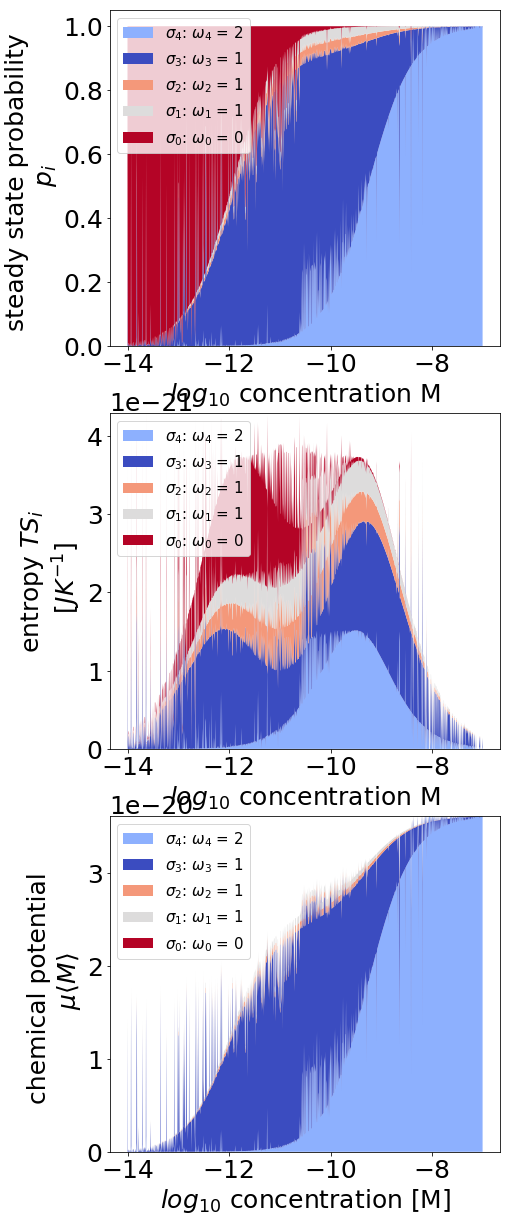

In [650]:
imp.reload(ctmc)
molar_concentrations = np.log10(concentrations_phaseplot_merge*10**-9)

entropies = []
free_energies = []
energies = []
chem_pots = []
for conc in range(0,len(concentrations_phaseplot_merge)):
    entropy = np.array(-1*denovo_sim_1.kB*phase_set_merge[conc]*np.log(phase_set_merge[conc]))
    entropies.append(entropy)
    denovo_sim_1.subconc = molar_concentrations[conc]
    q, e_vector = denovo_sim_1.solve_partition_function(phase_set_merge[conc],verbose=False)
    free_energy = np.array(e_vector)*phase_set_merge[conc] -(denovo_sim_1.particle_count_key.T[0]*denovo_sim_1.mu_mono*np.array(phase_set_merge[conc]) + denovo_sim_1.particle_count_key.T[1]*denovo_sim_1.mu_biv*np.array(phase_set_merge[conc]))- entropy
    chem_pot = (denovo_sim_1.particle_count_key.T[0]*denovo_sim_1.mu_mono*np.array(phase_set_merge[conc]) + denovo_sim_1.particle_count_key.T[1]*denovo_sim_1.mu_biv*np.array(phase_set_merge[conc]))
    energies.append(e_vector*phase_set_merge[conc])
    free_energies.append(free_energy)
    chem_pots.append(chem_pot)
    
energies =    np.array([i for i in energies])       
entropies =    np.array([i for i in entropies])      
free_energies = np.array([i for i in free_energies])      
chem_pots = np.array([i for i in chem_pots]) 
# import pickle as pkl

# import pickle as pkl
# denovo_sim_1,molar_concentrations,phase_set_merge, \
#           entropies, energies = \
#     pkl.load(open(master_name+'/pickle_directory/phasedataresult'+"bivalent_close"+'.pickle', 'rb'))


fig, axs = plt.subplots(3, figsize = (7,21))

try: 
    cmap = denovo_sim_1.statecolors
except:
    vals = np.linspace(0, 1, len(concentrations_phaseplot_merge))
    np.random.shuffle(vals)
    cmap_main = cm.get_cmap('coolwarm')
    cmap = cm.colors.ListedColormap(cmap_main(vals))


state_printout_limit = 5
labels = ["$\\sigma_{" + str(int(i)) + "}$: $\\omega_{" + str(int(i)) + "}$ = " + str(
                int(denovo_sim_1.occupancy_key[i]))  for i in denovo_sim_1.end_rankings[0:state_printout_limit]]


# print(np.shape(molar_concentrations),np.shape(entropies_transposed),np.shape(range(0,len(phase_set_merge))))
axs[0].stackplot(molar_concentrations, phase_set_merge.T[denovo_sim_1.end_rankings], colors=cmap,labels=labels,edgecolor=None)
axs[0].set_xlabel("$log_{10}$ concentration M", fontsize=25)
axs[0].set_ylabel("steady state probability \n $p_i$", fontsize=25)
axs[0].legend(loc='upper left', fontsize=15)


axs[1].stackplot(molar_concentrations, denovo_sim_1.Temp*entropies.T[denovo_sim_1.end_rankings], colors=cmap,labels=labels,edgecolor=None)
# axs[1].set_ylim((0, 1.5e-23))
axs[1].set_xlabel("$log_{10}$ concentration M", fontsize=25)
axs[1].set_ylabel("entropy $T S_i$ \n [$J K^{-1}$]")
axs[1].legend(loc='upper left', fontsize=15)


# axs[2].stackplot(molar_concentrations, energies.T[denovo_sim_1.end_rankings], colors=cmap,labels=labels,edgecolor=None)
# axs[2].set_ylim((0, .1e-19))
# axs[2].set_xlabel("$log_{10}$ concentration M", fontsize=25)
# axs[2].set_ylabel("average state energy \n $E_i p_i$ [$J$]")
# axs[2].legend(loc='upper left', fontsize=15)


# # np.array(e_vector)*np.array(stationary_distribution) -(self.particle_count_key.T[0]*self.mu_mono*np.array(stationary_distribution) + self.particle_count_key.T[1]*self.mu_biv*np.array(stationary_distribution))- self.Temp*self.kB*stationary_distribution*np.log(stationary_distribution)
# axs[3].stackplot(molar_concentrations, free_energies.T[denovo_sim_1.end_rankings], colors=cmap,labels=labels,edgecolor=None)
# axs[3].set_ylim((-1e-19,0))
# axs[3].set_xlabel("$log_{10}$ concentration M", fontsize=25)
# axs[3].set_ylabel("free energy \n $p_i E_i - TS_i$ [$J$]")
# axs[3].legend(loc='upper left', fontsize=15)



axs[2].stackplot(molar_concentrations, chem_pots.T[denovo_sim_1.end_rankings], colors=cmap,labels=labels,edgecolor=None)
axs[2].set_xlabel("$log_{10}$ concentration [M]", fontsize=25)
axs[2].set_ylabel("chemical potential \n $\\mu\\langle M \\rangle$", fontsize=25)
axs[2].legend(loc='upper left', fontsize=15)

plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25) 
plt.rcParams.update({'font.size': 25})
# axs[0].set_ylim((0, 1))
plt.savefig(master_name+"/phase_plots.svg")
plt.show()
plt.close()    

pkl.dump([denovo_sim_1,molar_concentrations,phase_set_merge, \
          entropies, energies, \
         ], open(master_name+'/pickle_directory/phasedataresult'+denovo_sim_1.transition_matrix_name+'.pickle', 'wb'))


In [98]:
((phase_set_merge.T[denovo_sim_1.end_rankings]).T*denovo_sim_2.occupancy_key).T

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.01519946e-04, 3.93999350e-04, 6.10156434e-03, ...,
        9.98163719e-01, 3.72149371e-03, 9.95196363e-01],
       [1.68275185e-07, 8.53131169e-06, 6.53775252e-03, ...,
        1.96022893e-04, 6.38165673e-02, 2.48204682e-04],
       [1.40420177e-07, 8.59557477e-06, 6.54109923e-03, ...,
        9.91269390e-05, 3.37551531e-01, 2.48204669e-04],
       [1.99919264e+00, 1.99888240e+00, 1.73466963e+00, ...,
        1.55710001e-04, 5.93597900e-01, 1.06226716e-07]])

In [9]:
import pickle as pkl
concentrations_phaseplot1, \
          phase_set1, conc_set1, stationary_p, stationary_p_test, \
          concentrations_phaseplot2     , \
          phase_set2, conc_set2, concentrations_phaseplot_merge, stationary_p_test, \
          phase_set2,phase_set_merge,denovo_sim_1,KD_fx = \
    pkl.load(open(master_name+'/pickle_directory/phasedataresult'+"bivalent_close"+'.pickle', 'rb'))

In [144]:
import pickle as pkl
molar_concentrations, \
          phase_set_merge, entropies, energies  = \
    pkl.load(open(master_name+'/pickle_directory/thermodata.pickle', 'rb'))

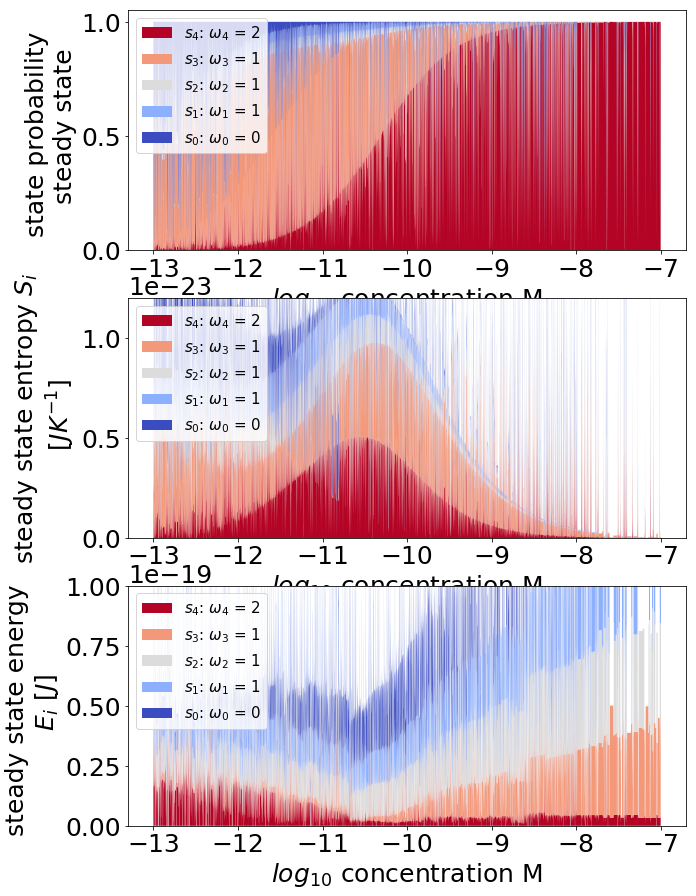

In [21]:
# fig, axs = plt.subplots(3, figsize = (10,15))

# state_printout_limit = 5
# labels = ["$\\sigma_{" + str(int(i)) + "}$: $\\omega_{" + str(int(i)) + "}$ = " + str(
#                 int(denovo_sim_1.occupancy_key[i]))  for i in denovo_sim_1.end_rankings[0:state_printout_limit]]

# # print(np.shape(molar_concentrations),np.shape(entropies_transposed),np.shape(range(0,len(phase_set_merge))))
# axs[0].stackplot(molar_concentrations, phase_set_merge.T[denovo_sim_1.end_rankings], colors=cmap,labels=labels,edgecolor=None)
# axs[0].set_xlabel("$log_{10}$ concentration M", fontsize=25)
# axs[0].set_ylabel("state probability \n steady state", fontsize=25)
# axs[0].legend(loc='upper left', fontsize=15)

# axs[1].stackplot(molar_concentrations, entropies.T[denovo_sim_1.end_rankings], colors=cmap,labels=labels,edgecolor=None)
# axs[1].set_ylim((0, 1.2e-23))
# axs[1].set_xlabel("$log_{10}$ concentration M", fontsize=25)
# axs[1].set_ylabel("steady state entropy $S_i$ \n [$J K^{-1}$]")
# axs[1].legend(loc='upper left', fontsize=15)

# axs[2].stackplot(molar_concentrations, energies.T[denovo_sim_1.end_rankings], colors=cmap,labels=labels,edgecolor=None)
# axs[2].set_ylim((0, 1e-19))
# axs[2].set_xlabel("$log_{10}$ concentration M", fontsize=25)
# axs[2].set_ylabel("steady state energy \n $E_i$ [$J$]")
# axs[2].legend(loc='upper left', fontsize=15)
# plt.savefig(output_directory+"/phase_plots.svg")
# # axs[0].set_ylim((0, 1))
# plt.show()
# plt.close()   

In [93]:
# imp.reload(ctmc)
# stationary_dist = denovo_sim_1.stationary_distribution(concentration = 1. ,guess_init=np.ones((len(denovo_sim_1.occupancy_key)))/len(denovo_sim_1.occupancy_key))
# state_entropies = denovo_sim_1.get_state_entropies(stationary_dist)
# Q, state_energies = denovo_sim_1.solve_partition_function(stationary_dist)

('solved partition function: ', 1.0475081503602044)
('output equilibrium probabilities: ', array([ 3.84738615e-05, -4.63298804e-06,  5.72682880e-04, -2.47211477e-05,
       -9.97032800e-05,  4.04355557e-04,  5.10550132e-04,  7.39314813e-03,
        4.13248599e-05,  4.24204479e-03,  5.93121537e-03,  9.80995262e-01]))
('input equilibrium probabilities: ', array([-5.82381581e-07, -6.16956276e-08,  4.23680505e-04, -3.27040198e-07,
        2.23880260e-06,  4.43571604e-04,  5.83890275e-04,  7.44486904e-03,
        6.49438514e-06,  4.11649860e-03,  5.85636621e-03,  9.81121543e-01]))
('solved energies: ', array([ 4.16319510e-20,             nan,  3.05221910e-20,             nan,
                   nan,  3.19540829e-20,  3.09946779e-20,  1.99981935e-20,
        4.13378476e-20,  2.22836588e-20,  2.09046499e-20, -1.12014957e-22]))


complete_ctmc_v1.py:196: RuntimeWarning: invalid value encountered in log
  entropies[state] = -1 * self.kB * equilibrium_p_dist[state] * np.log(equilibrium_p_dist[state])
complete_ctmc_v1.py:185: RuntimeWarning: invalid value encountered in log
  final_energies = -1 * self.kB * self.Temp * np.log(xopt.x)


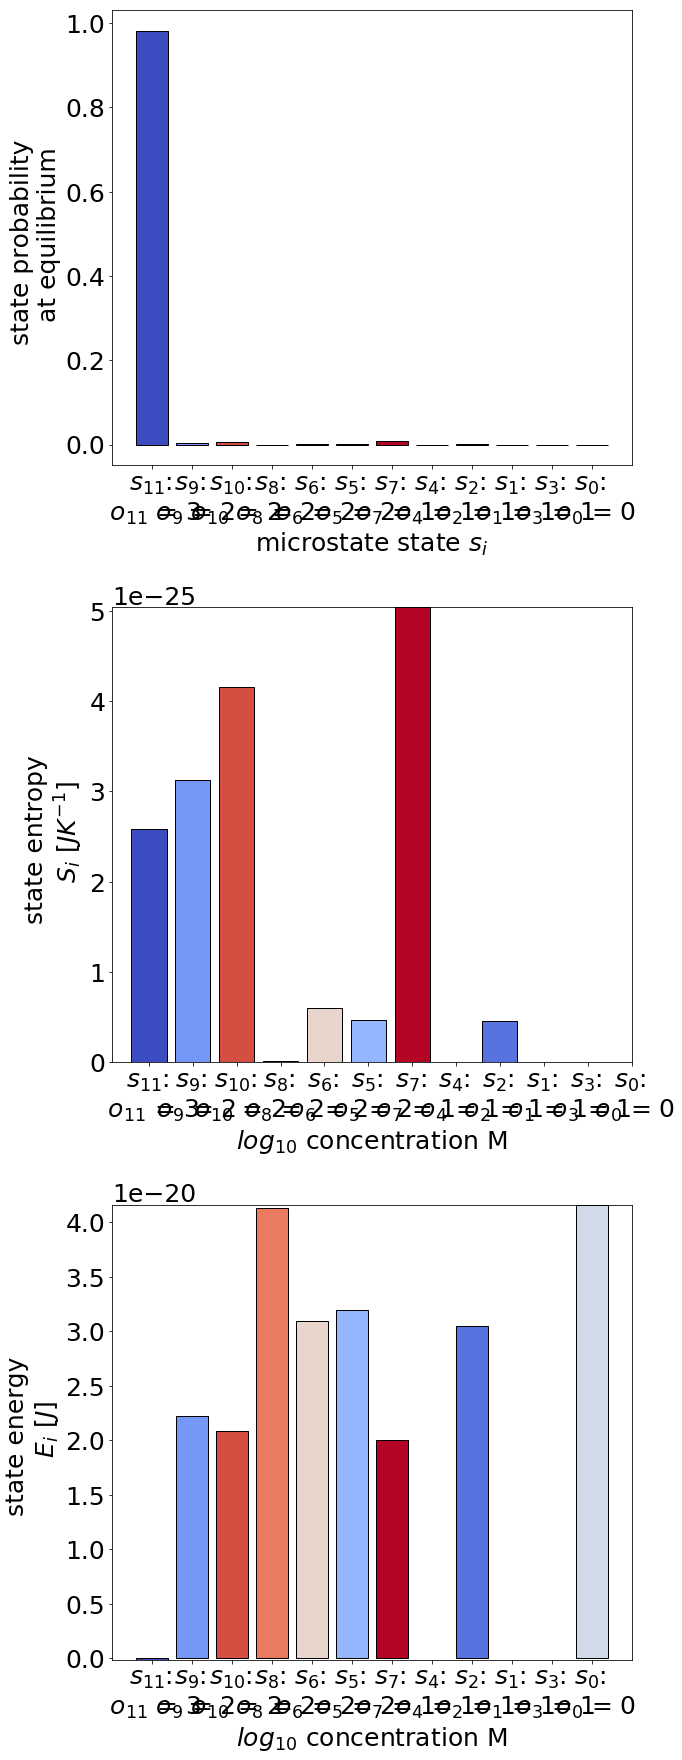

In [94]:
# try: 
#     cmap = denovo_sim_1.statecolors
# except:
#     vals = np.linspace(0, 1, len(concentrations_phaseplot_merge))
#     np.random.shuffle(vals)
#     cmap_main = cm.get_cmap('coolwarm')
#     cmap = cm.colors.ListedColormap(cmap_main(vals))

# labels = ["$\\sigma_{" + str(int(i)) + "}$: \n $o_{" + str(int(i)) + "}$ = " + str(
#                 int(denovo_sim_1.occupancy_key[i])) for i in denovo_sim_1.end_rankings]

# fig, axs = plt.subplots(3, figsize = (10,25))

# axs[0].bar(range(len(state_energies)), stationary_dist[denovo_sim_1.end_rankings], color=cmap,tick_label=labels,edgecolor='k')
# axs[0].set_xlabel("microstate state $s_i$", fontsize=25)
# axs[0].set_ylabel("state probability \n at equilibrium")

# axs[1].bar(range(len(state_entropies)), state_entropies[denovo_sim_1.end_rankings], color=cmap,tick_label=labels,edgecolor='k')
# axs[1].set_xlabel("$log_{10}$ concentration M", fontsize=25)
# axs[1].set_ylabel("state entropy \n $S_i$ [$J K^{-1}$]")
# # axs[1].set_ylim((0, 1.3e-24))

# axs[2].bar(range(len(state_energies)), state_energies[denovo_sim_1.end_rankings], color=cmap,tick_label=labels,edgecolor='k')
# axs[2].set_xlabel("$log_{10}$ concentration M", fontsize=25)
# axs[2].set_ylabel("state energy \n $E_i$ [$J$]")
# # axs[2].set_ylim((0, 4e-20))

# plt.tight_layout()
# # plt.ylim((0, 5e-20))
# plt.show()
# plt.close()

In [236]:
concentrations_phaseplot_merge

array([1.00000000e-05, 1.02329299e-05, 1.04712855e-05, 1.07151931e-05,
       1.09647820e-05, 1.12201845e-05, 1.14815362e-05, 1.17489755e-05,
       1.20226443e-05, 1.23026877e-05, 1.25892541e-05, 1.28824955e-05,
       1.31825674e-05, 1.34896288e-05, 1.38038426e-05, 1.41253754e-05,
       1.44543977e-05, 1.47910839e-05, 1.51356125e-05, 1.54881662e-05,
       1.58489319e-05, 1.62181010e-05, 1.65958691e-05, 1.69824365e-05,
       1.73780083e-05, 1.77827941e-05, 1.81970086e-05, 1.86208714e-05,
       1.90546072e-05, 1.94984460e-05, 1.99526231e-05, 2.04173794e-05,
       2.08929613e-05, 2.13796209e-05, 2.18776162e-05, 2.23872114e-05,
       2.29086765e-05, 2.34422882e-05, 2.39883292e-05, 2.45470892e-05,
       2.51711784e-05, 2.57039578e-05, 2.63026799e-05, 2.69153480e-05,
       2.75422870e-05, 2.81838293e-05, 2.88403150e-05, 2.95120923e-05,
       3.01995172e-05, 3.09029543e-05, 3.16227766e-05, 3.23593657e-05,
       3.31131121e-05, 3.38844156e-05, 3.46736850e-05, 3.54813389e-05,
      

[0.         0.         0.         ... 9.51404681 9.51404681 9.51404681]
0.9743766596535999


/home/ian/miniconda3/envs/seq2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


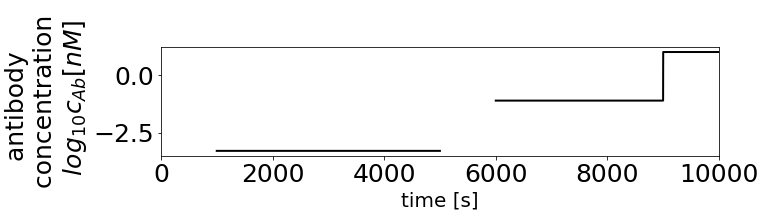

IOError: [Errno 2] No such file or directory: '/home/ian/projects/2020_antibody_master/003_visual_ctmc_w_energy_analysis/transition_matrices/bivalent_closeparticle_count_key.npy'

In [463]:
imp.reload(ctmc)
output_directory = master_name+"/bivalent_close"
if not os.path.exists(output_directory):
            os.makedirs(output_directory)

time_points = np.array([0,1000,5000,6000,9000])
final_time = 10000
concentrations = np.array([0,5.12861384e-04,0,7.58894470e-02,9.51404681e+00]) # nM   0.456 .0032 0.0767 9.51404681e+00 3.09029543e-02


weighted_concs = np.zeros((final_time))
timepoints_new = list(time_points) + [final_time]
for i in range(0, len(time_points)):
    for j in range(timepoints_new[i],timepoints_new[i+1]):
        weighted_concs[j] = concentrations[i]
print(weighted_concs)   
fixed_conc = np.average(weighted_concs)
print(fixed_conc)
plt.figure(figsize=(10, 2))
plt.plot(np.log10(weighted_concs),c="k", linewidth=2)
plt.xlim(0,final_time)
plt.ylabel("antibody \n concentration \n $log_{10}c_{Ab} [nM]$",fontsize=25)
plt.xlabel("time [s]",fontsize=20)
plt.savefig(output_directory+"/concentration_injections.svg")
plt.show()
plt.close()


mono_rates = np.array([0.02132598786, 0.0005306938055585968]) #nM-1 s-1  and s-1


KD_fx = [25.4726412,  0.27,       1.1,        0.33,       0.99]
denovo_sim_2 = ctmc.Simulation(transition_matrix_name = "bivalent_close", #12_16_20_right_triangle
                             mono_rates = mono_rates, 
                             KD_fx = KD_fx,
                             concentrations = concentrations, 
                             time_points = time_points, 
                             final_time = final_time) 

denovo_sim_2.print_graph=True
denovo_sim_2.SPR_run_advanced()



('monovalent binding energy via KD1', -7.43913492449083e-21)
('bivalent conversion energy via KD2', -8.889261989235232e-21)
('bivalent binding energy via KD2', -1.6328396913726066e-20)
('monovalent binding energy via Z', -1.8047951461574506e-20)
('bivalent conversion energy via Z', -9.451621848462794e-21)
('bivalent binding energy via Z', -2.74995733100373e-20)
('monovalent binding energy via KD1', -7.948402826743922e-21)
('bivalent conversion energy via KD2', -8.889261989235232e-21)
('bivalent binding energy via KD2', -1.6837664815979156e-20)
('monovalent binding energy via Z', -1.8053323746660226e-20)
('bivalent conversion energy via Z', -9.450479949138438e-21)
('bivalent binding energy via Z', -2.7503803695798667e-20)
('monovalent binding energy via KD1', -8.401518777447045e-21)
('bivalent conversion energy via KD2', -8.889261989235232e-21)
('bivalent binding energy via KD2', -1.7290780766682278e-20)
('monovalent binding energy via Z', -1.8047476807380002e-20)
('bivalent conversion 

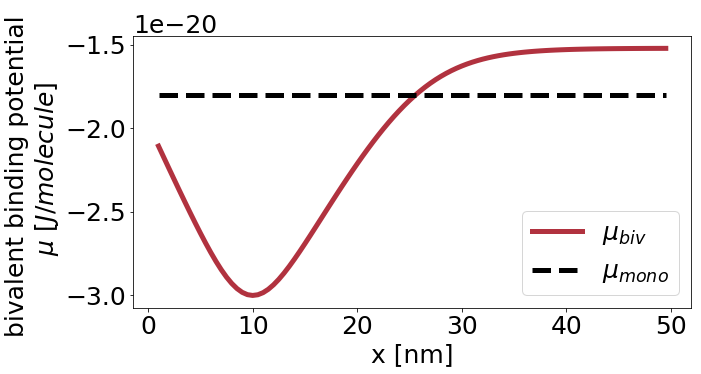

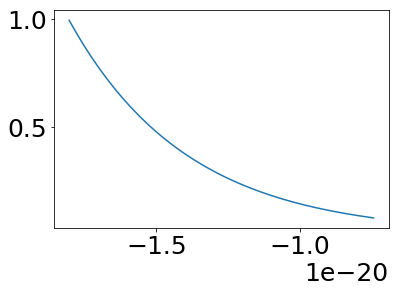

In [670]:
imp.reload(ctmc)
# conc =.2 #0.0767
concs = np.arange(7.58894470e-02,1, .01)
mono_potentials_K = []
mono_potentials_Z = []
biv_potentials_K = []
biv_potentials_Z = []
standalone_biv_potentials_K = []
standalone_biv_potentials_Z = []
for c in range(0,len(concs)):
    conc = concs[c]
    KD1 = denovo_sim_2.k_off/(denovo_sim_2.k_on*conc)
    
    # KD = KD1 * KD2
    
    
    #### mono via equilibrium constant ####
    dG_mono = -1*denovo_sim_2.kB * denovo_sim_2.Temp * np.log(2*1/(KD1))
    print("monovalent binding energy via KD1",dG_mono)
    mono_potentials_K.append(dG_mono)
    
    #### biv via equilibrium constant ####
    dG_biv = -1*denovo_sim_2.kB * denovo_sim_2.Temp * np.log(1/(2*ctmc.compute_KD(denovo_sim_2.KD_fx+[15])))
    print("bivalent conversion energy via KD2",dG_biv)
    biv_potentials_K.append(dG_biv)
    
    dG_sa_biv =  -1*denovo_sim_2.kB * denovo_sim_2.Temp * np.log(1/(KD1*ctmc.compute_KD(denovo_sim_2.KD_fx+[15])))
    print("bivalent binding energy via KD2",dG_sa_biv)
    standalone_biv_potentials_K.append(dG_sa_biv)
    
    #-1*denovo_sim_2.kB * denovo_sim_2.Temp * np.log(2/(KD1)) + -1*denovo_sim_2.kB * denovo_sim_2.Temp * np.log(1/(2*ctmc.compute_KD(denovo_sim_2.KD_fx+[15])))
    
    guess_init = np.ones((len(denovo_sim_2.occupancy_key))) 
    guess_init = guess_init / np.sum(guess_init)
    final_optimized_ps = denovo_sim_2.stationary_distribution(conc,guess_init=guess_init)
    
    #### mono via partition function ####
    dz_mono = -1*denovo_sim_2.kB * denovo_sim_2.Temp * np.log((final_optimized_ps[1]+final_optimized_ps[2])/final_optimized_ps[0])+1*denovo_sim_2.kB * denovo_sim_2.Temp * np.log(conc)
    print("monovalent binding energy via Z",dz_mono)
    mono_potentials_Z.append(dz_mono)
    
    #### biv via partition function ####
    dz_biv = -1*denovo_sim_2.kB * denovo_sim_2.Temp * np.log((final_optimized_ps[3])/(final_optimized_ps[2]+final_optimized_ps[1]))
    print("bivalent conversion energy via Z",dz_biv)
    biv_potentials_Z.append(dz_biv)
    
    dz_sa_biv=-1*denovo_sim_2.kB * denovo_sim_2.Temp * np.log((final_optimized_ps[3]/final_optimized_ps[0]))+1*denovo_sim_2.kB * denovo_sim_2.Temp * np.log(conc)
    print("bivalent binding energy via Z",dz_sa_biv)
    standalone_biv_potentials_Z.append(dz_sa_biv)
    
print(np.array([mono_potentials_K,mono_potentials_Z]).T)    
print(np.array([biv_potentials_K,biv_potentials_Z]).T)
print(np.array([standalone_biv_potentials_K,standalone_biv_potentials_Z]).T)
    
dists = np.arange(1,50,.5)
conversion_energies = np.zeros((len(dists)))
for dist in range(0,len(dists)):
    conversion_energies[dist] = -1*denovo_sim_2.kB * denovo_sim_2.Temp * np.log(2/(KD1))+ - 1*denovo_sim_2.kB * denovo_sim_2.Temp * np.log(1/(2*ctmc.compute_KD(denovo_sim_2.KD_fx+[dists[dist]])))
    #-1*denovo_sim_2.kB * denovo_sim_2.Temp * np.log(KD1/(2)) + -1*denovo_sim_2.kB * denovo_sim_2.Temp * np.log(2*ctmc.compute_KD(denovo_sim_2.KD_fx+[dists[dist]]))
#     denovo_sim_2.kB * denovo_sim_2.Temp * np.log(ctmc.compute_KD(denovo_sim_2.KD_fx+[dists[dist]]))
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(dists,conversion_energies, linewidth = 5, c="#B1323F")   
plt.plot(dists,dG_mono*np.ones(len(conversion_energies)), linewidth = 5, c="k",linestyle="dashed")   
plt.ylabel("bivalent binding potential \n $\\mu \ [J/molecule]$",fontsize=25)
plt.xlabel("x [nm]",fontsize=25)
ax.legend(["$\mu_{biv}$","$\mu_{mono}$"])
plt.savefig(master_name + "/deltaG_distance_dependence_curve.svg")

plt.show()
plt.close()

plt.plot(mono_potentials_K,concs)
plt.show()
plt.close()

[[1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99992131e-01 3.96593177e-07 4.55160069e-07 ... 3.48512398e-12
  1.44085580e-12 2.43560310e-18]
 [9.99984263e-01 5.38075312e-07 5.90305463e-07 ... 1.37867400e-11
  5.66487195e-12 9.77167407e-18]
 ...
 [1.55474447e-05 4.65239646e-04 4.65240812e-04 ... 1.87643416e-01
  7.41641807e-02 2.40040430e-01]
 [1.55391319e-05 4.65016611e-04 4.65017777e-04 ... 1.87576207e-01
  7.41376209e-02 2.40316237e-01]
 [1.55308644e-05 4.64794600e-04 4.64795767e-04 ... 1.87509156e-01
  7.41111234e-02 2.40591371e-01]]


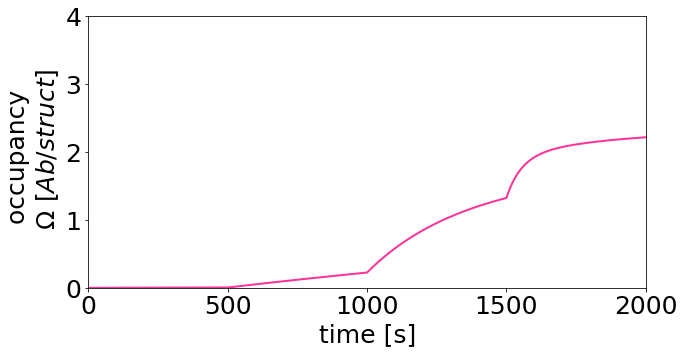

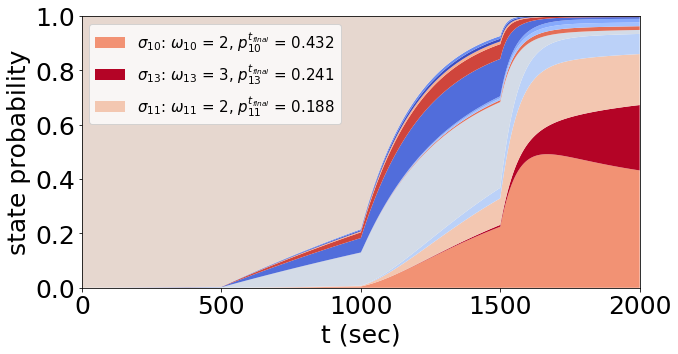

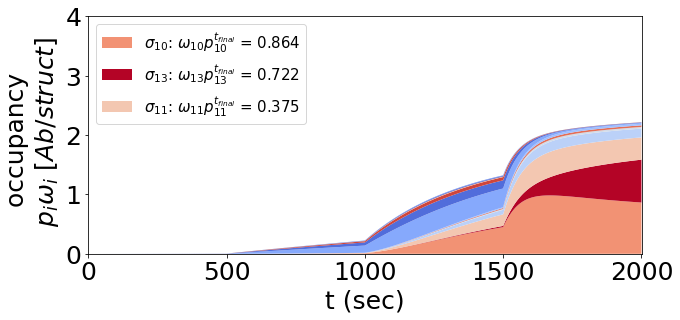

100%|██████████| 20/20 [03:59<00:00, 11.95s/it]


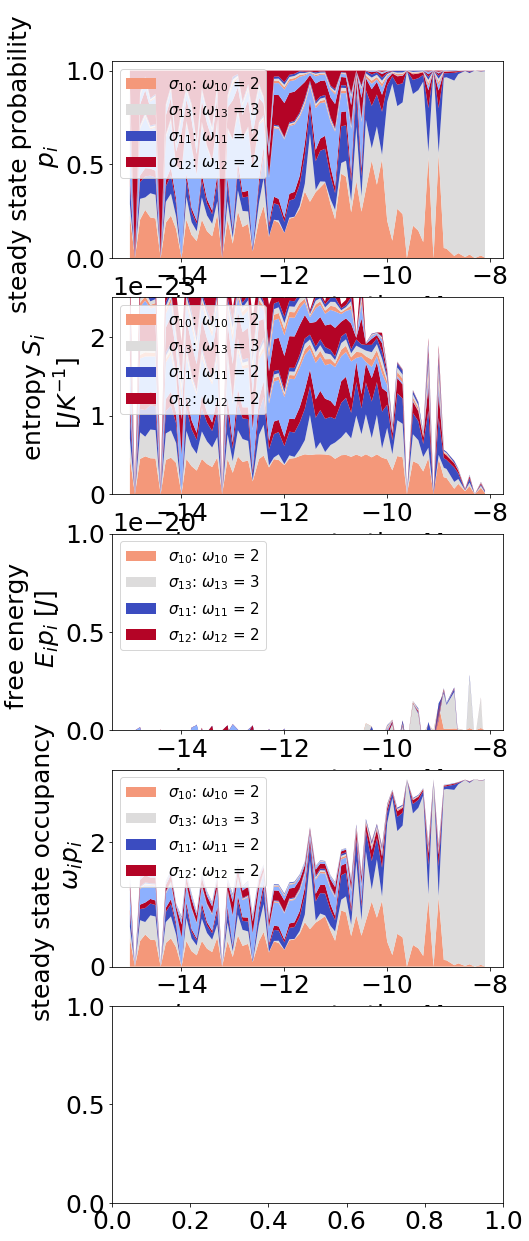

In [337]:
imp.reload(ctmc)
KD_fx = [25.4726412,  0.27,       1.1,        0.33,       0.99]
denovo_sim_4 = ctmc.Simulation(transition_matrix_name = "12_16_20_right_triangle",
                             mono_rates = mono_rates, 
                             KD_fx = KD_fx,
                             concentrations = concentrations, 
                             time_points = time_points, 
                             final_time = final_time) 
denovo_sim_4.print_graph=True
denovo_sim_4.SPR_run()
log_step = .1
concentrations_phaseplot1 = np.power(10.,np.arange(-5.,0.,log_step)[::-1])
phase_set1 = [] 
conc_set1  = []
# stationary_p =  np.ones((len(denovo_sim_1.occupancy_key))) / len(denovo_sim_1.occupancy_key)

for conc in tqdm(range(0,len(concentrations_phaseplot1))):
    repeat = True
    while repeat == True:
        repeat = False
        stationary_p = np.ones(len(denovo_sim_4.occupancy_key))
        stationary_p = stationary_p/np.sum(stationary_p)
        stationary_p_test = denovo_sim_4.stationary_distribution(concentration = concentrations_phaseplot1[conc],guess_init = stationary_p)
        for point in range(0,len(stationary_p_test)):
            if math.isnan(stationary_p_test[point]) or np.sum(stationary_p_test) != 1 or stationary_p_test[point]<0:
                repeat = True
                concentrations_phaseplot1[conc] = np.power(10,np.log10(concentrations_phaseplot1[conc])+log_step*np.random.normal(scale=0.1))
                
                break
    #             print("numerical solver failure, trying new conc: ", concentrations_phaseplot1[conc] )
        if repeat == False:
            stationary_p = stationary_p_test
            phase_set1.append(stationary_p)
            conc_set1.append(concentrations_phaseplot1[conc])
#             repeat = False
#             break
concentrations_phaseplot2 = np.power(10,np.arange(0.,2.,log_step))
phase_set2 = []
conc_set2  = []
stationary_p =  np.ones((len(denovo_sim_4.occupancy_key))) / len(denovo_sim_4.occupancy_key)
for conc in tqdm(range(0,len(concentrations_phaseplot2))):
    repeat = True
    while repeat == True:
        repeat = False
        stationary_p = np.ones(len(denovo_sim_4.occupancy_key))
        stationary_p = stationary_p/np.sum(stationary_p)
        stationary_p_test = denovo_sim_4.stationary_distribution(concentration = concentrations_phaseplot2[conc],guess_init = stationary_p)
        for point in range(0,len(stationary_p_test)):        
            if math.isnan(stationary_p_test[point]) or np.sum(stationary_p_test) != 1 or stationary_p_test[point]<0:
                repeat = True
                concentrations_phaseplot2[conc] = np.power(10,np.log10(concentrations_phaseplot2[conc])+log_step*np.random.normal(scale=0.1))
                break
#             print("numerical solver failure, trying new conc: ", concentrations_phaseplot2[conc] )
#         else:
        if repeat == False:
            stationary_p = stationary_p_test
            phase_set2.append(stationary_p)
            conc_set2.append(concentrations_phaseplot2[conc])

concentrations_phaseplot_merge =  np.array(conc_set1[::-1] + conc_set2)
phase_set_merge =  np.concatenate((np.array(phase_set1)[::-1], np.array(phase_set2)))

#################



imp.reload(ctmc)
molar_concentrations = np.log10(concentrations_phaseplot_merge*10**-10)

entropies = []
for conc in range(0,len(concentrations_phaseplot_merge)):
    entropies.append(denovo_sim_4.get_state_entropies(phase_set_merge[conc]))
entropies =    np.array([i for i in entropies])       

energies = []        
for conc in range(0,len(concentrations_phaseplot_merge)):
    q, e_vector = denovo_sim_4.solve_partition_function(phase_set_merge[conc],verbose=False)
    energies.append(e_vector)
energies =    np.array([i for i in energies])       

# import pickle as pkl

# import pickle as pkl
# denovo_sim_1,molar_concentrations,phase_set_merge, \
#           entropies, energies = \
#     pkl.load(open(master_name+'/pickle_directory/phasedataresult'+"bivalent_close"+'.pickle', 'rb'))


fig, axs = plt.subplots(4, figsize = (7,21))

try: 
    cmap = denovo_sim_4.statecolors
except:
    vals = np.linspace(0, 1, len(concentrations_phaseplot_merge))
    np.random.shuffle(vals)
    cmap_main = cm.get_cmap('coolwarm')
    cmap = cm.colors.ListedColormap(cmap_main(vals))


state_printout_limit = 5
labels = ["$\\sigma_{" + str(int(i)) + "}$: $\\omega_{" + str(int(i)) + "}$ = " + str(
                int(denovo_sim_4.occupancy_key[i]))  for i in denovo_sim_4.end_rankings[0:state_printout_limit]]


# print(np.shape(molar_concentrations),np.shape(entropies_transposed),np.shape(range(0,len(phase_set_merge))))
axs[0].stackplot(molar_concentrations, phase_set_merge.T[denovo_sim_4.end_rankings], colors=cmap,labels=labels,edgecolor=None)
axs[0].set_xlabel("$log_{10}$ concentration M", fontsize=25)
axs[0].set_ylabel("steady state probability \n $p_i$", fontsize=25)
axs[0].legend(loc='upper left', fontsize=15)


axs[1].stackplot(molar_concentrations, entropies.T[denovo_sim_4.end_rankings], colors=cmap,labels=labels,edgecolor=None)
axs[1].set_ylim((0, 2.5e-23))
axs[1].set_xlabel("$log_{10}$ concentration M", fontsize=25)
axs[1].set_ylabel("entropy $S_i$ \n [$J K^{-1}$]")
axs[1].legend(loc='upper left', fontsize=15)


axs[2].stackplot(molar_concentrations, energies.T[denovo_sim_4.end_rankings]*phase_set_merge.T[denovo_sim_4.end_rankings], colors=cmap,labels=labels,edgecolor=None)
axs[2].set_ylim((0, .1e-19))
axs[2].set_xlabel("$log_{10}$ concentration M", fontsize=25)
axs[2].set_ylabel("average state energy \n $E_i p_i$ [$J$]")
axs[2].legend(loc='upper left', fontsize=15)


# axs[3].stackplot(molar_concentrations, energies.T[denovo_sim_1.end_rankings]*phase_set_merge.T[denovo_sim_1.end_rankings] - denovo_sim_1.Temp*entropies.T[denovo_sim_1.end_rankings], colors=cmap,labels=labels,edgecolor=None)
# # axs[3].set_ylim((0, 1e-19))
# axs[3].set_xlabel("$log_{10}$ concentration M", fontsize=25)
# axs[3].set_ylabel("free energy \n $p_i E_i - TS_i$ [$J$]")
# axs[3].legend(loc='upper left', fontsize=15)


axs[3].stackplot(molar_concentrations, ((phase_set_merge.T[denovo_sim_4.end_rankings]).T*denovo_sim_4.occupancy_key[denovo_sim_4.end_rankings]).T, colors=cmap,labels=labels,edgecolor=None)
axs[3].set_xlabel("$log_{10}$ concentration M", fontsize=25)
axs[3].set_ylabel("steady state occupancy \n $\\omega_i p_i$", fontsize=25)
axs[3].legend(loc='upper left', fontsize=15)

plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25) 
plt.rcParams.update({'font.size': 25})
# axs[0].set_ylim((0, 1))
plt.savefig(master_name+"/phase_plots.svg")
plt.show()
plt.close()    

pkl.dump([denovo_sim_4,molar_concentrations,phase_set_merge, \
          entropies, energies, \
         ], open(master_name+'/pickle_directory/phasedataresult'+denovo_sim_4.transition_matrix_name+'.pickle', 'wb'))


In [406]:
concentrations_phaseplot_merge

array([1.00543420e-05, 1.25892541e-05, 1.58489319e-05, 1.99526231e-05,
       2.51188643e-05, 3.16227766e-05, 3.98107171e-05, 5.01187234e-05,
       6.30957344e-05, 7.94328235e-05, 1.01261947e-04, 1.25892541e-04,
       1.58489319e-04, 1.99526231e-04, 2.51188643e-04, 3.16227766e-04,
       3.98107171e-04, 5.01187234e-04, 6.22779506e-04, 7.94328235e-04,
       1.00000000e-03, 1.25892541e-03, 1.55389932e-03, 1.99526231e-03,
       2.44272909e-03, 3.24255382e-03, 3.98107171e-03, 5.05954890e-03,
       6.30957344e-03, 7.80126773e-03, 1.00705219e-02, 1.25892541e-02,
       1.58489319e-02, 1.99526231e-02, 2.51188643e-02, 3.16227766e-02,
       4.08906197e-02, 5.01187234e-02, 6.22984014e-02, 7.94328235e-02,
       9.72993547e-02, 1.28043235e-01, 1.58489319e-01, 1.99526231e-01,
       2.51188643e-01, 3.16227766e-01, 3.85886015e-01, 5.01187234e-01,
       6.30957344e-01, 7.94328235e-01, 1.00000000e+00, 1.25892541e+00,
       1.57308600e+00, 1.99526231e+00, 2.41594258e+00, 3.16227766e+00,
      

In [ ]:
# fig, axs = plt.subplots(4, figsize = (20,100))

# state_printout_limit = 5
# labels = ["$\\sigma_{" + str(int(i)) + "}$: $\\omega_{" + str(int(i)) + "}$ = " + str(
#                 int(denovo_sim_1.occupancy_key[i]))  for i in denovo_sim_1.end_rankings[0:state_printout_limit]]

# # print(np.shape(molar_concentrations),np.shape(entropies_transposed),np.shape(range(0,len(phase_set_merge))))
# axs[0].stackplot(molar_concentrations, phase_set_merge.T[denovo_sim_1.end_rankings], colors=cmap,labels=labels,edgecolor=None)
# axs[0].set_xlabel("$log_{10}$ concentration M", fontsize=25)
# axs[0].set_ylabel("state probability \n at equilibrium", fontsize=25)
# axs[0].legend(loc='upper left', fontsize=15)

# axs[1].stackplot(molar_concentrations, entropies.T[denovo_sim_1.end_rankings], colors=cmap,labels=labels,edgecolor=None)
# axs[1].set_ylim((0, 1.2e-23))
# axs[1].set_xlabel("$log_{10}$ concentration M", fontsize=25)
# axs[1].set_ylabel("state entropy $S_i$ \n [$J K^{-1}$]")
# axs[1].legend(loc='upper left', fontsize=15)

# axs[2].stackplot(molar_concentrations, energies.T[denovo_sim_1.end_rankings]*phase_set_merge.T[denovo_sim_1.end_rankings], colors=cmap,labels=labels,edgecolor=None)
# axs[2].set_ylim((0, 1e-19))
# axs[2].set_xlabel("$log_{10}$ concentration M", fontsize=25)
# axs[2].set_ylabel("state internal energy \n $E_i p_i$ [$J$]")
# axs[2].legend(loc='upper left', fontsize=15)

# axs[3].stackplot(molar_concentrations, energies.T[denovo_sim_1.end_rankings]*phase_set_merge.T[denovo_sim_1.end_rankings] - denovo_sim_1.Temp*entropies.T[denovo_sim_1.end_rankings], colors=cmap,labels=labels,edgecolor=None)
# axs[3].set_ylim((0, 1e-19))
# axs[3].set_xlabel("$log_{10}$ concentration M", fontsize=25)
# axs[3].set_ylabel("state free energy \n $p_i E_i - TS_i$ [$J$]")
# axs[3].legend(loc='upper left', fontsize=15)

# # axs[0].set_ylim((0, 1))
# plt.savefig(output_directory+"/phase_plots.svg")
# plt.show()
# plt.close()    

[5.01187234e-04 5.01187234e-04 5.01187234e-04 ... 1.25892541e+00
 1.25892541e+00 1.25892541e+00]
0.9019488091815556


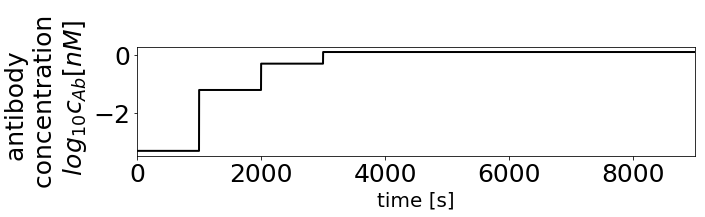

[[1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99967938e-01 1.61596077e-06 1.85459741e-06 ... 5.78632569e-11
  2.39224224e-11 1.64773042e-16]
 [9.99935879e-01 2.19240250e-06 2.40521373e-06 ... 2.28897604e-10
  9.40523657e-11 6.61065283e-16]
 ...
 [3.70784397e-06 1.87580025e-04 1.87580025e-04 ... 1.30217398e-01
  5.14684563e-02 4.80083589e-01]
 [3.70784397e-06 1.87580025e-04 1.87580025e-04 ... 1.30217398e-01
  5.14684563e-02 4.80083589e-01]
 [3.70784397e-06 1.87580025e-04 1.87580025e-04 ... 1.30217398e-01
  5.14684563e-02 4.80083589e-01]]


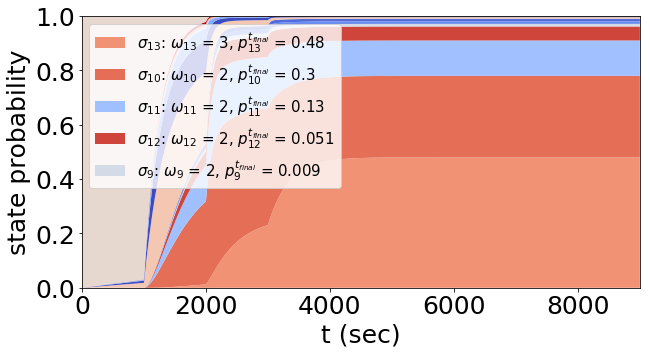

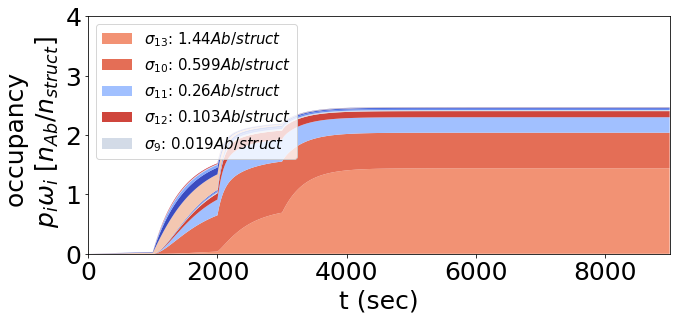

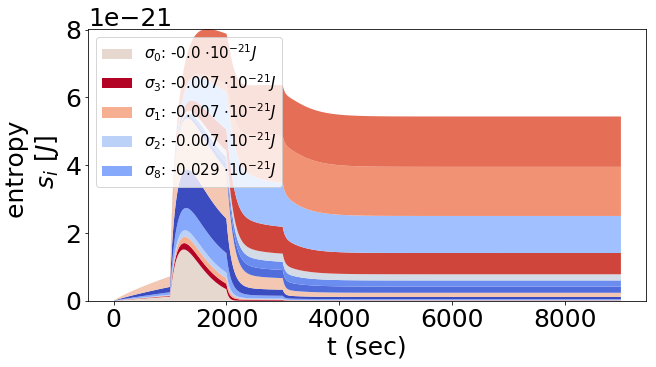

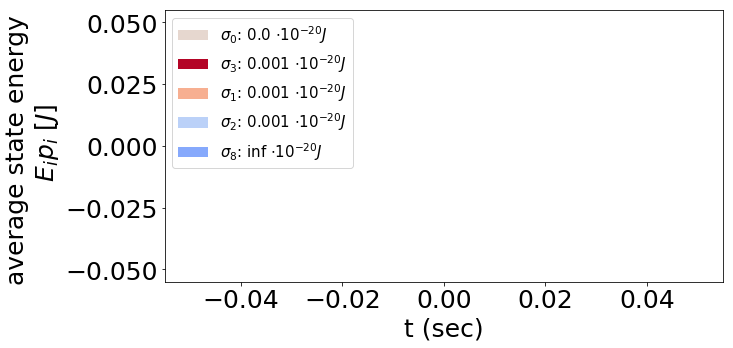

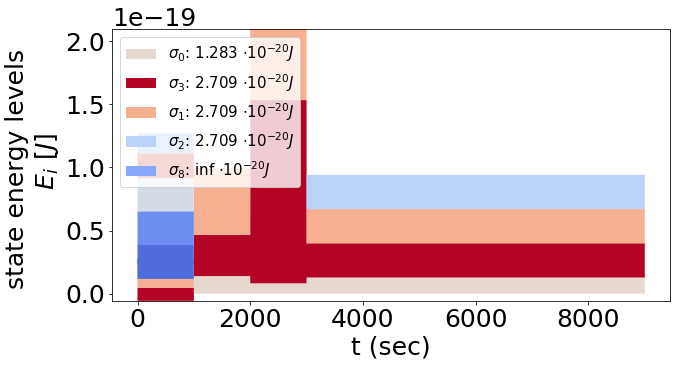

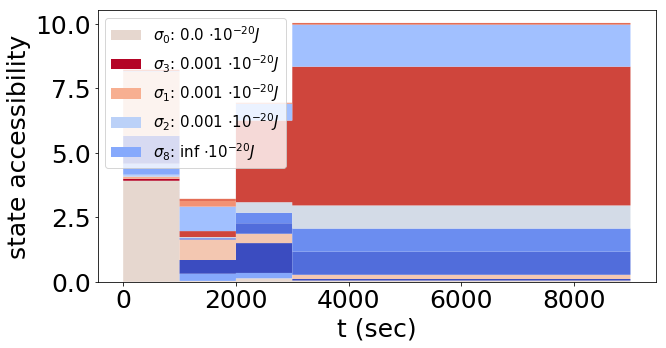

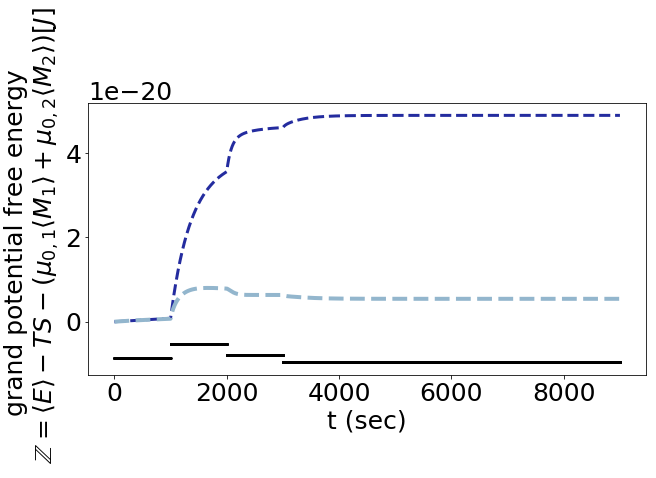

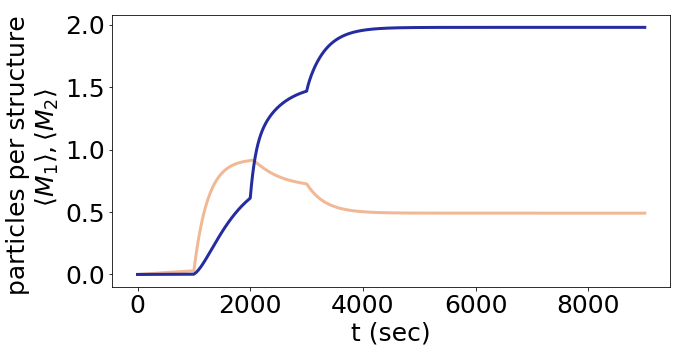

0

In [682]:
imp.reload(ctmc)
tm_name = "triangle_asym"
output_directory = master_name+"/"+tm_name
if not os.path.exists(output_directory):
            os.makedirs(output_directory)

time_points = np.array([0,1000,2000,3000])#,6000,8000])
final_time = 9000
concentrations = np.array([5.01187234e-04,6.22984014e-02,5.01187234e-01,1.25892541e+00]) # nM   0.456 .0032 0.0767 9.51404681e+00
steady_state_dists = []

weighted_concs = np.zeros((final_time))
timepoints_new = list(time_points) + [final_time]
for i in range(0, len(time_points)):
    for j in range(timepoints_new[i],timepoints_new[i+1]):
        weighted_concs[j] = concentrations[i]
print(weighted_concs)   
fixed_conc = np.average(weighted_concs)
print(fixed_conc)
plt.figure(figsize=(10, 2))
plt.plot(np.log10(weighted_concs),c="k", linewidth=2)
plt.xlim(0,final_time)
plt.ylabel("antibody \n concentration \n $log_{10}c_{Ab} [nM]$",fontsize=25)
plt.xlabel("time [s]",fontsize=20)
plt.savefig(output_directory+"/concentration_injections.svg")
plt.show()
plt.close()


mono_rates = np.array([0.02132598786, 0.0005306938055585968]) #nM-1 s-1  and s-1


KD_fx = [25.4726412,  0.27,       1.1,        0.33,       0.99]
for c in range(0,len(concentrations)):
    denovo_sim_2 = ctmc.Simulation(transition_matrix_name = tm_name, #12_16_20_right_triangle
                                 mono_rates = mono_rates, 
                                 KD_fx = KD_fx,
                                 concentrations = [concentrations[c]], 
                                 time_points = [0], 
                                 final_time = 100000) 
    denovo_sim_2.print_graph=False
    denovo_sim_2.SPR_run()
    steady_state_dists.append(denovo_sim_2.probability_vectors[-1])


denovo_sim_2 = ctmc.Simulation(transition_matrix_name = tm_name, #12_16_20_right_triangle
                             mono_rates = mono_rates, 
                             KD_fx = KD_fx,
                             concentrations = concentrations, 
                             time_points = time_points, 
                             final_time = final_time)


denovo_sim_2.stationary_distribution_suggestion = steady_state_dists
denovo_sim_2.print_graph=True
denovo_sim_2.SPR_run_advanced()

[0.05 0.05 0.05 ... 0.9  0.9  0.9 ]
0.4750000000000002


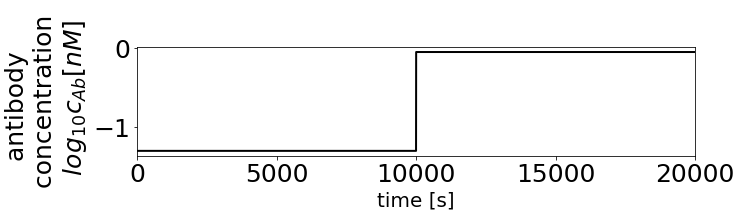

[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [9.97869908e-01 3.17559618e-04 3.17559618e-04 1.49450114e-03
  4.71485034e-07]
 [9.95744510e-01 4.16987522e-04 4.16987522e-04 3.42025950e-03
  1.25562025e-06]
 ...
 [4.75988251e-04 1.72148753e-02 1.72148753e-02 3.42490800e-01
  6.22603461e-01]
 [4.75988251e-04 1.72148753e-02 1.72148753e-02 3.42490800e-01
  6.22603461e-01]
 [4.75988251e-04 1.72148753e-02 1.72148753e-02 3.42490800e-01
  6.22603461e-01]]


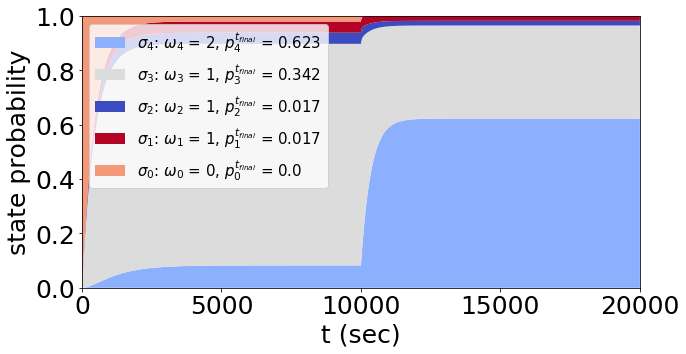

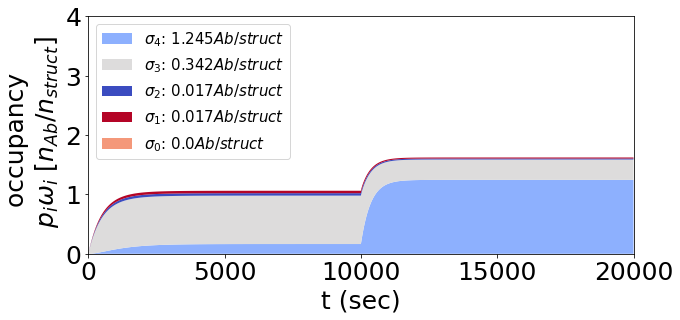

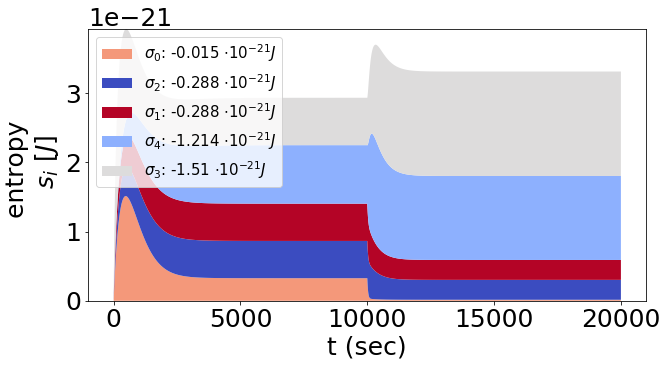

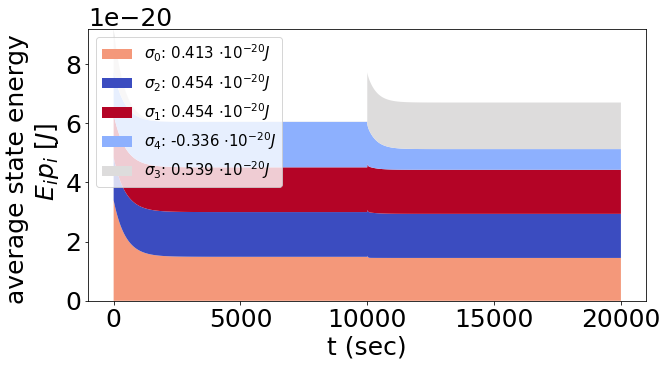

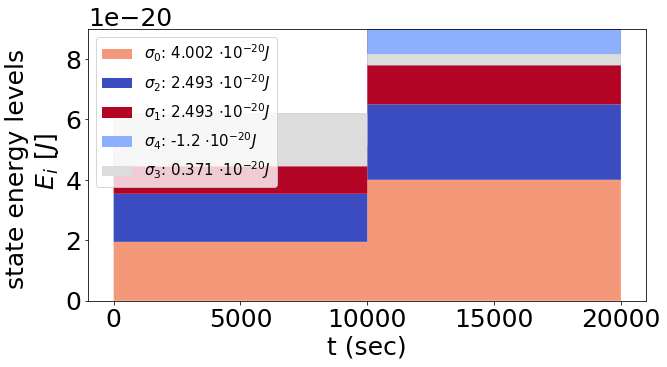

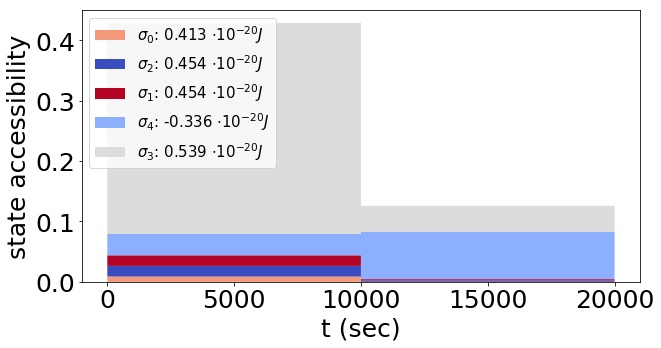

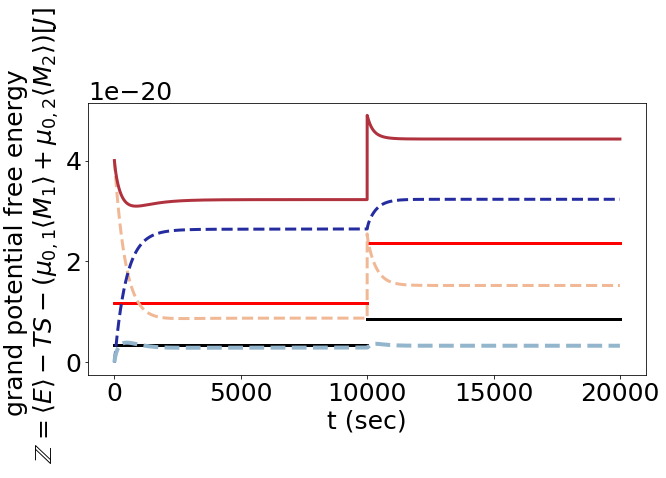

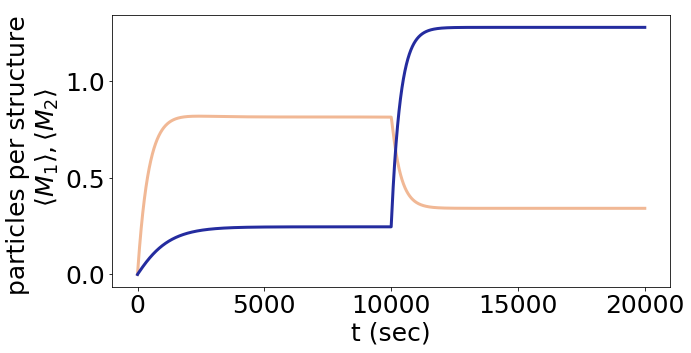

0

In [674]:
imp.reload(ctmc)
tm_name = "14p4_bivalent"
output_directory = master_name+"/"+tm_name
if not os.path.exists(output_directory):
            os.makedirs(output_directory)

time_points = np.array([0,10000])
final_time = 20000
concentrations = np.array([.05,0.9])#,1.25892541e+00,2.00935092e+01]) # nM   0.456 .0032 0.0767 9.51404681e+00
steady_state_dists = []

weighted_concs = np.zeros((final_time))
timepoints_new = list(time_points) + [final_time]
for i in range(0, len(time_points)):
    for j in range(timepoints_new[i],timepoints_new[i+1]):
        weighted_concs[j] = concentrations[i]
print(weighted_concs)   
fixed_conc = np.average(weighted_concs)
print(fixed_conc)
plt.figure(figsize=(10, 2))
plt.plot(np.log10(weighted_concs),c="k", linewidth=2)
plt.xlim(0,final_time)
plt.ylabel("antibody \n concentration \n $log_{10}c_{Ab} [nM]$",fontsize=25)
plt.xlabel("time [s]",fontsize=20)
plt.savefig(output_directory+"/concentration_injections.svg")
plt.show()
plt.close()


mono_rates = np.array([0.02132598786, 0.0005306938055585968]) #nM-1 s-1  and s-1


KD_fx = [25.4726412,  0.27,       1.1,        0.33,       0.99]
for c in range(0,len(concentrations)):
    denovo_sim_2 = ctmc.Simulation(transition_matrix_name = tm_name, #12_16_20_right_triangle
                                 mono_rates = mono_rates, 
                                 KD_fx = KD_fx,
                                 concentrations = [concentrations[c]], 
                                 time_points = [0], 
                                 final_time = 100000) 
    denovo_sim_2.print_graph=False
    denovo_sim_2.SPR_run()
    steady_state_dists.append(denovo_sim_2.probability_vectors[-1])


denovo_sim_2 = ctmc.Simulation(transition_matrix_name = tm_name, #12_16_20_right_triangle
                             mono_rates = mono_rates, 
                             KD_fx = KD_fx,
                             concentrations = concentrations, 
                             time_points = time_points, 
                             final_time = final_time)


denovo_sim_2.stationary_distribution_suggestion = steady_state_dists
denovo_sim_2.print_graph=True
denovo_sim_2.SPR_run_advanced()